# HOG-based Pedestrian Detection
* Author: Johannes Maucher
* Last update: 03.03.2021

The extraction of HoG-descriptors from image-patches has been demonstrated step-by-step in [notebook HoGfeatures.ipynb](HoGfeatures.ipynb). Fortunately, we do not have to implement each of these steps by ourselves. Instead we can apply libraries, which already provide functions that calculate HoG-descriptors. In this notebook we demonstrate how the [opencv HOGDescriptor](https://docs.opencv.org/2.4/modules/gpu/doc/object_detection.html) can be applied to 
* calculate the HoG-descriptor of an image-patch
* detect all persons in a given image.

**References:**


[opencv documentation of HOGDescriptor](https://docs.opencv.org/2.4/modules/gpu/doc/object_detection.html)

[configuration remarks on stackoverflow](https://stackoverflow.com/questions/28390614/opencv-hogdescripter-python)

[Blog-Post on HoG-based person detection](http://mccormickml.com/2013/05/09/hog-person-detector-tutorial/)

[Another Blog-Post on HoG-based person detection:](https://www.pyimagesearch.com/2015/11/09/pedestrian-detection-opencv/)

In [1]:
#!pip install imutils

In [2]:
%matplotlib inline
import cv2
import imutils
import numpy as np
from imutils.object_detection import non_max_suppression
from matplotlib import pyplot as plt

<class 'numpy.ndarray'>


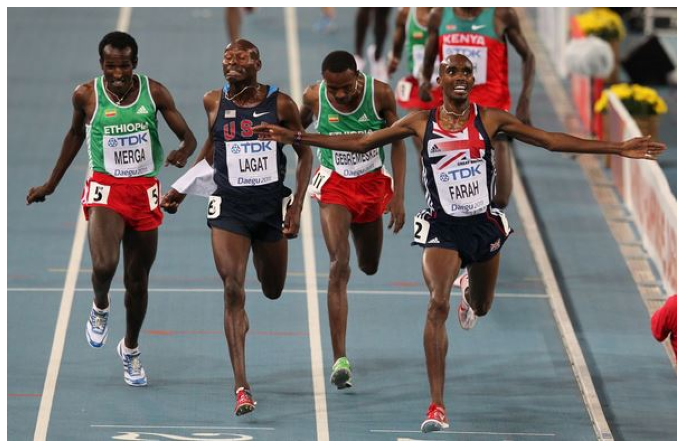

In [3]:
imagePath="../Data/mo.png"
image = cv2.imread(imagePath)
print(type(image))
plt.figure(figsize=(12,10))
plt.axis("off")
plt.imshow(image)
plt.show()
#orig = image.copy()

## Compute Hog-descriptor for image patch
In order to compute the HoG-descriptor for an image patch, first a `HOGDescriptor`-object has to be generated. Then this object's `compute()`-method has to be invoked, which returns the descriptor for the specified patch.

A `HOGDescriptor`-object with default parameters can be instantiated as follows:

In [4]:
hog = cv2.HOGDescriptor()
#help(cv2.HOGDescriptor())

It is also possible to configure the object with individual parameters:

In [5]:
winSize = (64,128) # size of the patch, for which HoG-descriptor shall be calculated
blockSize = (16,16) # size of the super-region, over which histogram are normalized
blockStride = (8,8) # step-size for shifting the super-region window
cellSize = (8,8) # size of region, for which a single histogram shall be extracted
nbins = 9 # number of bins in the histogram
derivAperture = 1 
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection,nlevels)

Next, the `compute()`-method of the `HOGDescriptor`-object `hog` is invoked for calculating the HoG-descriptors of the defined image-patch. In the code cell below the descriptors of the $(64,128)$-size patch in the upper left region of the image is calculated. It is a vector of length 3780. 

In [6]:
winStride = (16,16) 
padding = (8,8)  #border around the defined patch is included into the HoG-Descriptor (provides context information)
locations = ((0,0),) #multiple locations can be defined here

#hist = hog.compute(image) #calculates hog-desciptor over entire image, with default winStride = (8,8)
#hist = hog.compute(image,winStride) #calculates hog-desciptor over entire image, with the defined winStride as shift between adjacent image patches 
#hist = hog.compute(image,winStride,padding) 
hist = hog.compute(image,winStride,padding,locations)

In [7]:
print(hist.shape)

(3780, 1)


First 36 bins components of the HoG-descriptor and check if this first part of the HoG-descriptor is actually normallized:

In [8]:
print("L2-Norm of first 36 bins (4 HoGs within one super-region): {0:1.3f}".format(np.linalg.norm(hist[:36],ord=2)))
print(hist[:36])
print(np.sqrt(np.sum(hist[:36]**2)))

L2-Norm of first 36 bins (4 HoGs within one super-region): 0.998
[[0.10601729]
 [0.07673807]
 [0.0649855 ]
 [0.02065422]
 [0.35392162]
 [0.00805591]
 [0.05674358]
 [0.09173512]
 [0.093297  ]
 [0.08724247]
 [0.20235252]
 [0.20124237]
 [0.03218067]
 [0.35392162]
 [0.04375343]
 [0.06293514]
 [0.03583387]
 [0.04311533]
 [0.12474634]
 [0.09762604]
 [0.0747407 ]
 [0.02655543]
 [0.35392162]
 [0.05397325]
 [0.15274493]
 [0.12854901]
 [0.10992992]
 [0.15319496]
 [0.2227499 ]
 [0.23004755]
 [0.06804734]
 [0.35392162]
 [0.18343164]
 [0.28703865]
 [0.11235818]
 [0.09268625]]
0.9982305


## Person Detection based on HoG-Descriptors

HoG-descriptors can be applied e.g. for the detection of objects of a specific category in an image. They have been proven to be particularly good in pedestrian-detection ([Dalal and Triggs; Histograms of Oriented Gradients for Human Detection](http://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf).)

For the task of pedestrian detection 
1. a large set of HoG-descriptors must be generated. Each of these descriptors must be labeled with the corresponding class-index, which indicates wether there is a pedestrian in the image-patch or not. 
2. a part of the labeled HoG-descriptors is used for training a classifier, e.g. a Support-Vector-Machine (SVM) or a Multi-Layer-Perceptron (MLP).
3. The other part of the labeled HoG-descriptors is applied for evaluation of the trained classifier

The training-process is described in detail in this [Blog-post in HoG-based object detection](https://www.pyimagesearch.com/2014/11/10/histogram-oriented-gradients-object-detection/).

The *opencv*-library already provides a trained SVM for pedestrian detection. This classifier can be accessed via the `HoGDescriptor`-object as demonstrated in the code-cells below:

In [9]:
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

After setting of the SVM-Detector as in the code-cell above, the `detectMultiScale()`-method can be applied to detect people in the image in multiple scales. The method returns the coordinates of bounding boxes around the detected people:

In [10]:
# detect people in the image
(rects, weights) = hog.detectMultiScale(image, winStride=(4, 4),padding=(8, 8), scale=1.1)

In [11]:
print(rects)
print(weights)

[[336 172 102 205]
 [388 156  72 145]
 [341  68 134 267]
 [219 105 134 267]
 [133  10 168 336]
 [ 13   3 178 355]]
[[0.44302808]
 [0.81805863]
 [0.54987878]
 [0.93047954]
 [0.49410774]
 [1.49478267]]


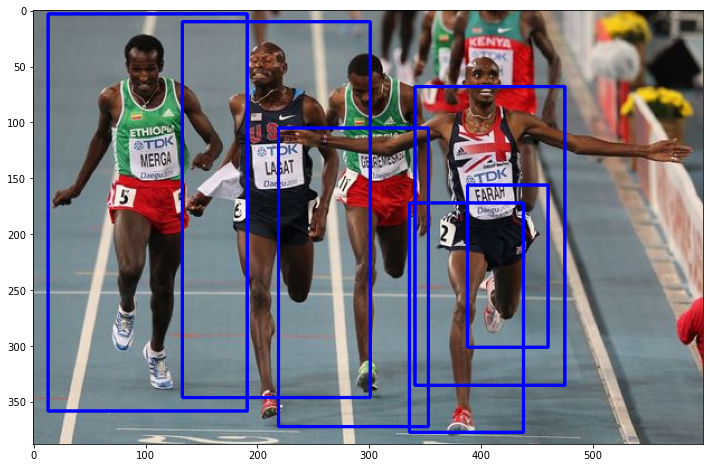

In [12]:
orig = image.copy()
# draw the original bounding boxes
for (x, y, w, h) in rects:
    cv2.rectangle(orig, (x, y), (x + w, y + h), (0, 0, 255), 2)
plt.figure(figsize=(12,10))
plt.imshow(orig)
plt.show()

Sometimes many bounding boxes strongly overlap, i.e. they have a high ratio of intersection. These bounding boxes usually refer to the same object. Since, each object shall be detected only once, the overlapping bounding boxes are usually mapped to a single one - typically the largest one. This technique is called *Non-Maxium-Suppression*. It is implemented e.g. in the [imutils library](https://github.com/jrosebr1/imutils) and can be applied like in the code-cell below: 

In [13]:
rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in rects])
pick = non_max_suppression(rects, probs=None, overlapThresh=0.65)

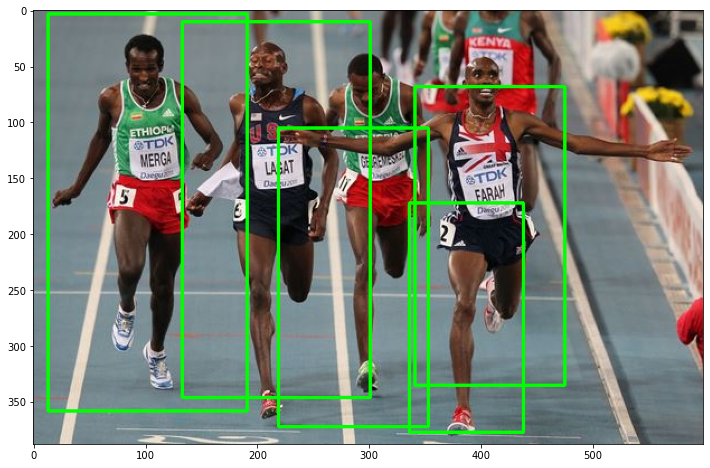

In [14]:
orig = image.copy()
plt.figure(figsize=(12,10))
# draw the final bounding boxes
for (xA, yA, xB, yB) in pick:
    cv2.rectangle(orig, (xA, yA), (xB, yB), (0, 255, 0), 2)
plt.imshow(orig)
plt.show()

In [15]:
# show some information on the number of bounding boxes
filename = imagePath[imagePath.rfind("/") + 1:]
print("[INFO] {}: {} original boxes, {} after suppression".format(filename, len(rects), len(pick)))

[INFO] mo.png: 6 original boxes, 5 after suppression


## Person Tracking in Video
The following code-cell demonstrates how detection of pedestrians in images can be applied to track pedestrians in videos. The applied video is provided by and can be downloaded from this [EPFL CVLAB page](https://cvlab.epfl.ch/data/pom). 

In [16]:
file="../Data/4p-c1.avi"
#file="../6p-c3.avi"
cam = cv2.VideoCapture(file)
print("Video Properties:")
print("\t Width: ",cam.get(cv2.CAP_PROP_FRAME_WIDTH))
print("\t Height: ",cam.get(cv2.CAP_PROP_FRAME_HEIGHT))
#print "\t FourCC: ",cam.get(cv2.CAP_PROP_FOURCC)
print("\t Framerate: ",cam.get(cv2.CAP_PROP_FPS))
NofFrames=cam.get(7)
print(("\t Number of Frames: ",NofFrames))
frameCount=0
while True and frameCount<NofFrames:
    img2 = cam.read()[1]
    frameCount+=1
    try:
        (rects, weights) = hog.detectMultiScale(img2,winStride=(4, 4),padding=(8, 8), scale=1.15)

        # draw the original bounding boxes
        for (x, y, w, h) in rects:
            cv2.rectangle(img2, (x, y), (x + w, y + h), (0, 0, 255), 2)

        # apply non-maxima suppression to the bounding boxes 
        rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in rects])
        pick = non_max_suppression(rects, probs=None, overlapThresh=0.65)

        # draw the final bounding boxes
        for (xA, yA, xB, yB) in pick:
            cv2.rectangle(img2, (xA, yA), (xB, yB), (0, 255, 0), 2)

        cv2.imshow("Video",img2)
    except:
        print("Frame can not be displayed")
    if cv2.waitKey(33) == 27: 
        break
cam.release()
cv2.destroyAllWindows()

Video Properties:
	 Width:  360.0
	 Height:  288.0
	 Framerate:  25.0
('\t Number of Frames: ', 3915.0)
